<a href="https://colab.research.google.com/github/VondracekS/ExplainabilityExchange/blob/master/ExplainerDashboardDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainer Dashboard Demo - penguin dataset

In [1]:
pip install explainerdashboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.9/286.9 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import plotly.express as px
from explainerdashboard import ExplainerDashboard, ClassifierExplainer
from seaborn import load_dataset

In [3]:
from sklearn.model_selection import train_test_split
data = load_dataset("penguins")
data_train, data_test = train_test_split(data)

In [4]:
for elem in [data_train, data_test]:
  print(elem.shape)

(258, 7)
(86, 7)


In [5]:
data_train.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [6]:
fig = px.scatter_matrix(data_train, color='species', template='ggplot2')
fig.update_layout(autosize=False, width=1500, height=1000, title = "Penguins Scatter Matrix plot")

In [7]:
data_train.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [8]:
data_train.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [9]:
[elem for elem in data_train.columns if data_train[elem].dtype == 'object']
[elem for elem in data_train.columns if data_train[elem].dtype != 'object']

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

cat_features = [col for col in data_train.columns if data_train[col].dtype == 'object']
num_features = [col for col in data_train.columns if data_train[col].dtype != 'object']

numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='mean')),
           ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant')),
        ('encoder', OrdinalEncoder())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, num_features),
        ('categorical', categorical_transformer, cat_features)
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()), 
        ('encoder', OrdinalEncoder()),
        ('imputer', SimpleImputer(strategy="median"))
    ]
)

train_transformed = pd.DataFrame(pipeline.fit_transform(data_train), columns=pipeline.get_feature_names_out())
test_transformed = pd.DataFrame(pipeline.fit_transform(data_test), columns=pipeline.get_feature_names_out())
# pipe = Pipeline(steps=[('scaler', StandardScaler()), ('encoder', OrdinalEncoder())
#                        ('imputer', SimpleImputer(strategy="median"))])
# pipe.fit_transform(data_train)

train_transformed.columns

Index(['numeric__bill_length_mm', 'numeric__bill_depth_mm',
       'numeric__flipper_length_mm', 'numeric__body_mass_g',
       'categorical__species', 'categorical__island', 'categorical__sex'],
      dtype='object')

In [16]:
(X_train, X_test, y_train, y_test) = (train_transformed.drop('categorical__species', axis=1), 
                                      test_transformed.drop('categorical__species', axis=1),
                                      train_transformed['categorical__species'],
                                      test_transformed['categorical__species'])

In [17]:
X_train

,numeric__bill_length_mm,numeric__bill_depth_mm,numeric__flipper_length_mm,numeric__body_mass_g,categorical__island,categorical__sex
0,133.0,56.0,21.0,17.0,1.0,1.0
1,103.0,18.0,38.0,82.0,0.0,1.0
2,91.0,9.0,40.0,48.0,0.0,0.0
3,29.0,44.0,11.0,16.0,1.0,0.0
4,124.0,62.0,17.0,31.0,1.0,1.0
...,...,...,...,...,...,...
253,41.0,35.0,3.0,10.0,1.0,0.0
254,27.0,38.0,10.0,12.0,2.0,2.0
255,71.0,8.0,31.0,53.0,0.0,0.0
256,1.0,58.0,14.0,23.0,2.0,0.0


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier()
fit = model.fit(X_train, y_train)
preds = fit.predict(X_test)

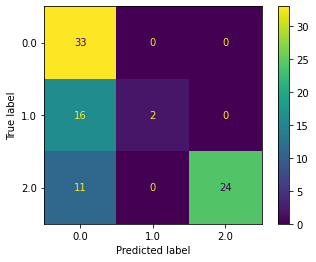

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels = model.classes_)
disp.plot()

In [30]:
preds

array([0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 2., 0., 2., 0., 0., 2., 2.,
       2., 2., 1., 0., 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       2., 2., 0., 0., 0., 0., 2., 0., 2., 0., 0., 2., 0., 0., 0., 2., 2.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 2., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [28]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
explainer = ClassifierExplainer(model, X_test, y_test)

Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [43]:
ExplainerDashboard(explainer, mode='external')

Building ExplainerDashboard..
Generating layout...
Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
